# Modern Data Science
**(Module 07: Natural Language Processing)**

---
- Materials in this module include resources collected from various open-source online repositories.
- You are free to use, but NOT allowed to change or distribute this package.

Prepared by and for 
**Student Members** |
2006-2019 [TULIP Lab](http://www.tulip.org.au)

---

# Session F - Topic Model - LDA

## Contents

1 [Computing with Language: Texts and Words](#Computing)
* Getting Started with Python
* Getting Started with NLTK
* Searching Text
* Counting Vocabulary

## Import the packages

In [1]:
from nltk.corpus import stopwords
from nltk import stem,pos_tag
import re
from collections import Counter
import numpy as np
%pylab inline
from textblob import TextBlob
from sklearn.metrics import silhouette_score,confusion_matrix,accuracy_score,roc_curve
import pandas as pd
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize,Normalizer
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
import ftfy
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.grid_search import GridSearchCV
import statsmodels.api as sm
from seaborn import lmplot
import os  # for os.path.basename
import matplotlib as mpl
from sklearn.manifold import MDS,TSNE
%pylab inline
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD,PCA,NMF
from sklearn.pipeline import make_pipeline
from sklearn.decomposition.online_lda import LatentDirichletAllocation

Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['stem']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id = "Function"></a>

## <span style="color:#0b486b">Function to get titles of talks</span>

In [2]:
def get_titles_from_talks(talks):
    
    title = []
    # For all the talks in that category
    for talk in talks:
        # if the talk is not empty
        if talk != "":
            # split talk and the header
            h,s = talk.lower().split("\n\n")
            # Header contains the title and the number of views
            t,v = h.split("\n")
            # Get the titles
            title.append(t)
    return title

In [3]:
!pip install wget

Requirement not upgraded as not directly required: wget in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages


In [6]:
import wget

entertainment = 'https://github.com/ShaoniWang/NLP-with-Python/blob/master/data/entertainment.txt?raw=true'
entertainment = wget.download(entertainment) 

technology = 'https://github.com/ShaoniWang/NLP-with-Python/blob/master/data/technology.txt?raw=true'
technology = wget.download(technology) 

science  = 'https://github.com/ShaoniWang/NLP-with-Python/blob/master/data/science.txt?raw=true'
science = wget.download(science) 

business = 'https://github.com/ShaoniWang/NLP-with-Python/blob/master/data/business.txt?raw=true'
business = wget.download(business) 

global_issues = 'https://github.com/ShaoniWang/NLP-with-Python/blob/master/data/global_issues.txt?raw=true'
global_issues = wget.download(global_issues) 

In [8]:
with open(entertainment, 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks= list(set((talks)))
       
ent = get_titles_from_talks(talks)



with open(technology, 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
tech = get_titles_from_talks(talks)




with open(science, 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
science = get_titles_from_talks(talks)




with open(business, 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
business = get_titles_from_talks(talks)




with open(global_issues, 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")
    
talks = list(set((talks)))
       
glob = get_titles_from_talks(talks)

<a id = "Getting"></a>

## <span style="color:#0b486b">Getting the talks that occur only once over the whole corpus.</span>

In [9]:
topic_c = Counter()
# loop over all the talk-titles in each of the category
for topic in [ent,tech,glob,business,science]:
    #increment the counter for that title if it occurs more than once
    topic_c += Counter(topic)
# unzip the counter object
topic,c = zip(*topic_c.items())
# select the talks that only occur once
titles = np.array(topic)[np.where(np.array(c)==1)]



### These single letter labels make it easy to unserstand the output in some places

s -> science --- 0

t -> Technology --- 1

b ->business --- 2

g ->global --- 3

e -> entertainment ---4


## Creating a dictionary of labels for all the talks

## These are the actual labels : I'm getting them beacuse I'm loading talks category wise.

In [10]:
d = {}

for title in titles:
    if title in tech:  # Talks in technology  have title "t"
        d[title]="t"
    if title in ent:# Talks in entertainment  have title "e"
        d[title]="e"
    if title in business: # Talks in business  have title "b"
        d[title]="b"
    if title in glob: # Talks in global issues  have title "g"
        d[title]="g"
    if title in science: # Talks in science  have title "s"
        d[title]="s"

## Category sizes/splits :

### business = 123

### entertainment = 152

### global issues = 245

### science = 209

### technology = 249

In [11]:
Counter(d.values())

Counter({'b': 123, 'e': 152, 'g': 245, 's': 209, 't': 249})

----

# we donot have much class imbalance. 

# Base line accuracy is 25-30%

-----

## Loading all the documents together, retaining all the punctuations to get a proper count of pauses and question marks for EDA

In [12]:
allt =  'https://github.com/ShaoniWang/NLP-with-Python/blob/master/data/all.txt?raw=true'
allt = wget.download(allt) 

In [15]:
# !pip install nltk

Requirement not upgraded as not directly required: nltk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from nltk)


In [19]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

In [20]:
#Loading the file that contains all the talks. These belong to all the categories that we have
with open(allt, 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")

talks = list(set((talks)))
lemma = WordNetLemmatizer()
stop_w = stopwords.words("english")
views = []
speeches = []
title = []
labels = []
senti = []
talks.remove("")

# loop over talks
for talk in talks:
    

    # Split the header and the actual speech
    h,s = talk.lower().split("\n\n")
    #split the header , that contains title and the views
    t,v = h.split("\n")
    # If that title is predent in the talks that are unique , which we computed earlier
    if t in d:
        # some punctuation removal
        s = s.replace(". "," ").replace(", "," ").replace(","," ").replace("."," ").replace("  "," ").replace('"'," ")

        # removing stop words
        s = " ".join(i for i in s.split() if i not in stop_w)
        
        f = TextBlob(s)
        senti.append(f.polarity)
        
        speeches.append(s)
       
        labels.append(d[t])
        views.append(v)
        title.append(t)

## Creating labels in terms of numbers is useful, some functions need them .

In [21]:
# Creating a list of labels in terms on numbers

num_label = []
for i in labels:
    if i =="s":
        num_label.append(0)
    if i =="t":
        num_label.append(1)
    if i =="b":
        num_label.append(2)
    if i =="g":
        num_label.append(3)
    if i ==s:
        num_label.append(3)
    if i =="e":
        num_label.append(4)


## Counting functions for EDA

In [22]:
def count_pause(speeches):
    counts = []
    for s in speeches:
        counts.append(s.count("--")+s.count(" --")+s.count("-- "))
    return counts  
def count_questions(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("?")+s.count(" ?")+s.count("? "))
    return counts 
def count_laughters(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("(laughter)")+s.count("laughter"))
    return counts 
def count_applause(speeches):
    counts= []
    for s in speeches:
        counts.append(s.count("(applause)")+s.count("applause"))
    return counts 


In [23]:
views = np.array(views).astype(int)
d_ = {"views":views,"labels":labels,'sentiment':senti,'pause': count_pause(speeches), 'questions': count_questions(speeches),'laughter':count_laughters(speeches),"applause":count_applause(speeches)}
df_eda = pd.DataFrame(data=d_)

## EDA and summary stats:

In [24]:
df_ = df_eda.groupby("labels").sum()
df_

,applause,laughter,pause,questions,sentiment,views
labels,,,,,,
b,465,1094,2466,1859,15.458044,311733541
e,1033,2239,3620,2250,19.483729,299570723
g,1038,1130,5030,2689,23.235819,299169383
s,713,1747,3912,2272,24.158276,358767319
t,1200,1825,4437,2693,32.669421,383874921


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


Text(0.5,1,'sentiment')

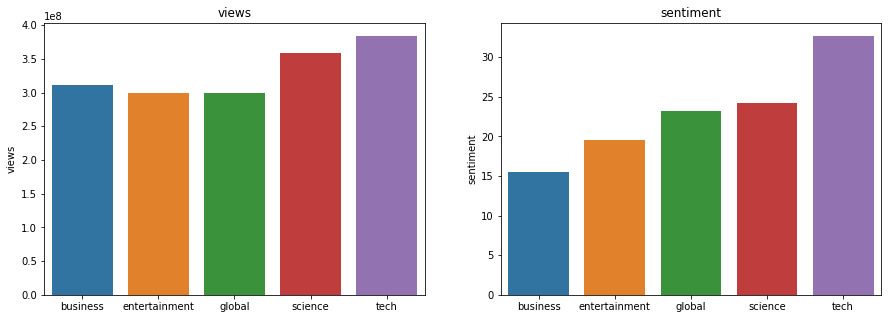

In [25]:
import seaborn as sns
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.barplot(["business","entertainment","global","science","tech"],df_.views)
plt.title("views")
plt.subplot(1,2,2)
sns.barplot(["business","entertainment","global","science","tech"],df_.sentiment)
plt.title("sentiment")

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):
/opt/conda/envs/DSX-

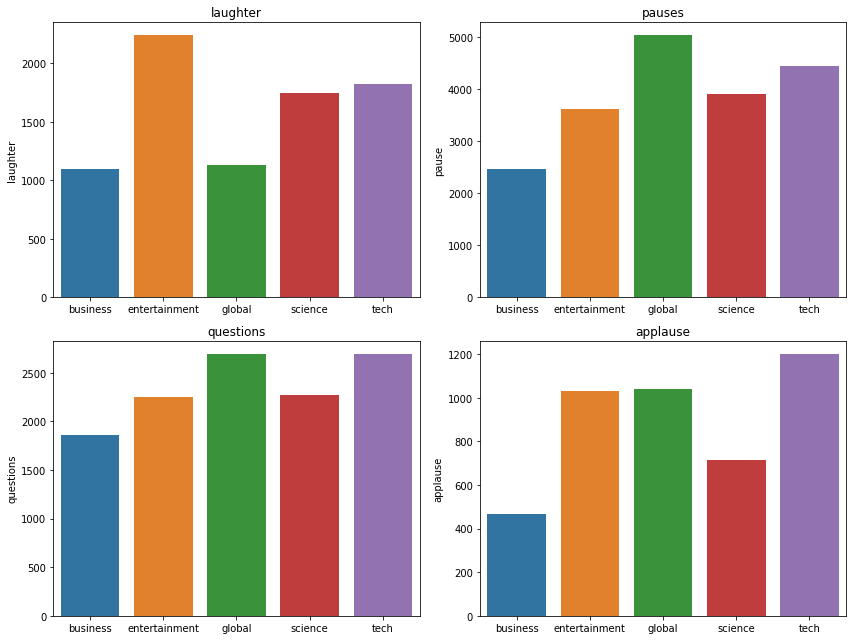

In [26]:
plt.figure(figsize=(12,9))
plt.subplot(2,2,1)
sns.barplot(["business","entertainment","global","science","tech"],df_.laughter)
plt.title("laughter")
plt.subplot(2,2,2)
sns.barplot(["business","entertainment","global","science","tech"],df_.pause)
plt.title("pauses")
plt.subplot(2,2,3)
sns.barplot(["business","entertainment","global","science","tech"],df_.questions)
plt.title("questions")
plt.subplot(2,2,4)
sns.barplot(["business","entertainment","global","science","tech"],df_.applause)
plt.title("applause")
plt.tight_layout()

In [27]:
view = np.array(df_eda.views).astype(int)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


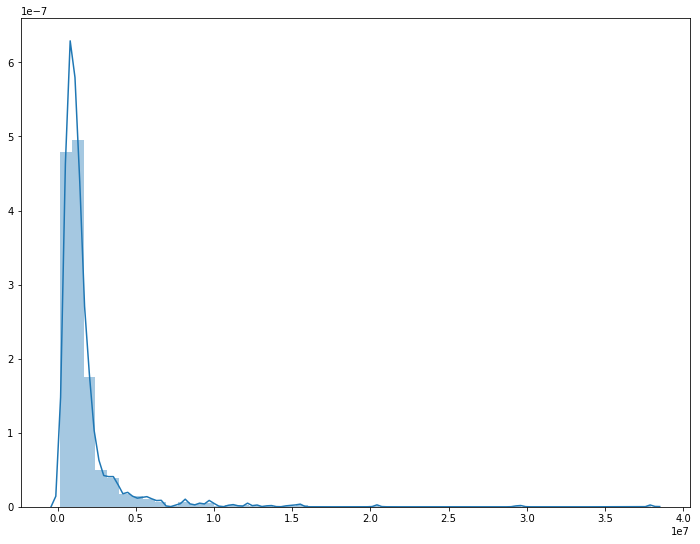

In [28]:
plt.figure(figsize=(12,9))
sns.distplot(view);

## Load all documents together, with all the preprocessing steps included

## Pre-processing:

1)  encoding

2) punctuation and symbols 

3)stop words removal

4) Lemmatization 

5)POS tagging  retaining NN and NNP


In [29]:
stop_w = stopwords.words("english")
stop_w.extend(["say","we're","said","things","becae","jt","it's",'one','like','people','going','know',"that's",'think','see','really',"get","would","i'm","don't","us","actually","may","always","found","fact","lost","you've","end"])
stop_w.extend(["sided","something","thing","got","also","we've","there's","time","well","way","want","could","first","two","new","they're","you're","take","back","need","many","kind","ever","four","five","used","maybe","start"])
stop_w.extend(["go","right","make","look","much","even","little","good","work","lot","put","use","three","come","around","different","another","i'll","ask","took","came","tell","great","find","i've","give","went","called","didn't","talk"])
stop_w.extend(["every","thank","day","big","can't","made","started","still","might","let's","idea","000","what's","years","year","able","start","example","question","show","problem","next","part","let","ago","doesn't","he's","here's","help"])
stop_w.extend(["almost","living","none","we'd","people's","using","says","okay","yet","10","second","i'd","goes","try","point","20","without","getting","happen","anything","else","wheather","true","ok","30","isn't","per","given","others","we'll","wouldn't","size","who's"])
stop_w.extend(["yeah","simple","laughing","laughter","(laughter)"])

In [30]:
with open(allt, 'r', encoding='utf-8') as f:
    talks = ftfy.fix_text(f.read()).split("\n\n\n\n")

talks = list(set((talks)))
lemma = WordNetLemmatizer()
views = []
speeches = []
title = []
labels = []
talks.remove("")

for talk in talks:
    


    h,s = talk.lower().split("\n\n")
    
    t,v = h.split("\n")
    
    if t in d:
        
        #BASIC PUNCTUATION REMOVAL
        
        s = s.replace(". "," ").replace(", "," ").replace(","," ").replace("."," ").replace("  "," ").replace('"'," ")
        s = s.replace("-- "," ").replace(" --"," ").replace("? "," ").replace("?"," ").replace("  "," ")
        s = re.sub(r"\((.\w+)\)","",s)
        
        #STOP WORDS removal and LEMMATIZING
        
        s = " ".join(lemma.lemmatize(i) for i in s.split() if i not in stop_w)
        
    
        words,tag = zip(*pos_tag(s.split()))
        # POS tagging 
        index = set(np.where(np.array(tag)=="NN")[0])
        np_index = set(np.where(np.array(tag)=="NNP")[0])
        index = list(index.union(np_index))
 
        words = np.array(words)[index]
        s = " ".join(i for i in words)
        speeches.append(s)
       
        labels.append(d[t])
        views.append(v)
        title.append(t)

## checking the word counts for better understanding

In [31]:
c = Counter()
#for each speech
for s in speeches:
    # counter for words
    c += Counter(s.split())
from operator import itemgetter
sorted_ = sorted(c.items(),key = itemgetter(1),reverse=True)[:10]
w,c = zip(*sorted_)

## Plotting the word counts 

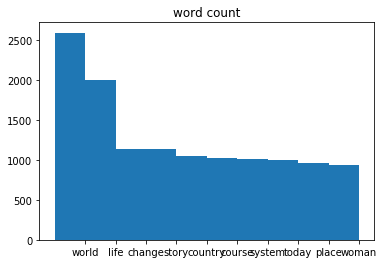

In [32]:
indexes = np.arange(len(w))
width = 1

plt.bar(indexes, c, width)
plt.xticks(indexes + width * 0.5, w)
plt.title("word count")
plt.show()

## Count Vectorizer, Tfidf vectorizer

In [33]:
df = pd.DataFrame(speeches)
df.columns=["speeches"]
df["labels"]=labels
# TFIDF VECTORIZER

tfidf_model =TfidfVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)

vectorized_tfidf = tfidf_model.fit_transform(df.speeches)

#COUNT VECTORIZER

tf_model =CountVectorizer(max_df=0.95 , min_df=2  , stop_words=stop_w)

vectorized_tf = tf_model.fit_transform(df.speeches)


## Visualizing the TFIDF vectors using a manifold similarity between document vectors:

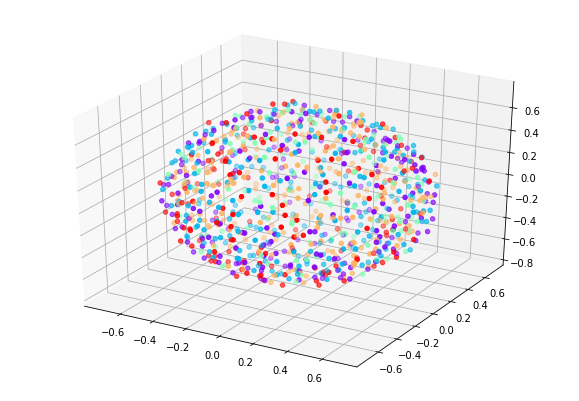

In [34]:
dist = 1 - cosine_similarity(vectorized_tfidf)
MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys, zs = pos[:, 0], pos[:, 1],pos[:,2]

fig = pylab.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection ="3d")
sc = ax.scatter(xs,ys,zs,c=num_label,cmap=plt.cm.rainbow)


> Visualizing the similarities among the document vectors. There is no clear pattern , but we will see by the end of the project that the doc2vec document vectors will make more sense. 

## Running LDA  on count vectorized documents. LDA on count vectorized vectors gave better results as compared to LDA on TFIDF.

In [35]:
# build LDA model

lda = LatentDirichletAllocation(n_topics=5,
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=42)

lda.fit(vectorized_tf)
topics_words = lda.components_
words = tf_model.get_feature_names()

# Print the words that represent the topics

def print_top_words(model,words,n_top_words=20):
    for index,topic in enumerate(model.components_):
        print("Topic #%d:" % index)
        print("|".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
print("Topics in LDA model:")
tf_feature_names = tf_model.get_feature_names()
print_top_words(lda, tf_feature_names)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topics in LDA model:
Topic #0:
slime|shark|mold|oat|il|coeur|bathe|moi|world|pour|emperor|camel|story|preston|pup|experimentwas|la|lapse|mon|water
Topic #1:
finger|dh|thumb|rhythm|ball|barry|moment|juggler|juggling|grab|grandmaster|space|announcer|node|today|life|story|world|richard|bullet
Topic #2:
world|life|change|country|today|system|percent|course|place|technology|number|story|school|computer|sort|city|state|money|car|child
Topic #3:
brain|life|story|woman|cell|cancer|man|compassion|body|god|world|hand|image|eye|heart|disease|person|love|drug|mind
Topic #4:
heh|fraud|loan|vulture|choir|crisis|liar|spider|soprano|fetus|dog|bank|woman|control|recipe|life|loss|world|food|regulator


a,b=zip(*nltk.pos_tag(speeches[2].split()))
index = np.where(np.array(b)=="NN")
list(index).extend(np.where(np.array(b)=="NNP"))
np.array(a)[index]

## How LDA performs compares to the actual labels that we have :

In [36]:
v = lda.transform(vectorized_tf)
Counter([np.argmax(i) for i in v])

Counter({0: 1, 2: 762, 3: 213, 4: 2})

> It doesnt perform that well, we can see that the documents are unevenly distributed among the clusters. But we donot have any class imbalance in our data.

In [41]:
filename = 'https://github.com/ShaoniWang/NLP-with-Python/raw/master/images/LDA_clusters.png'

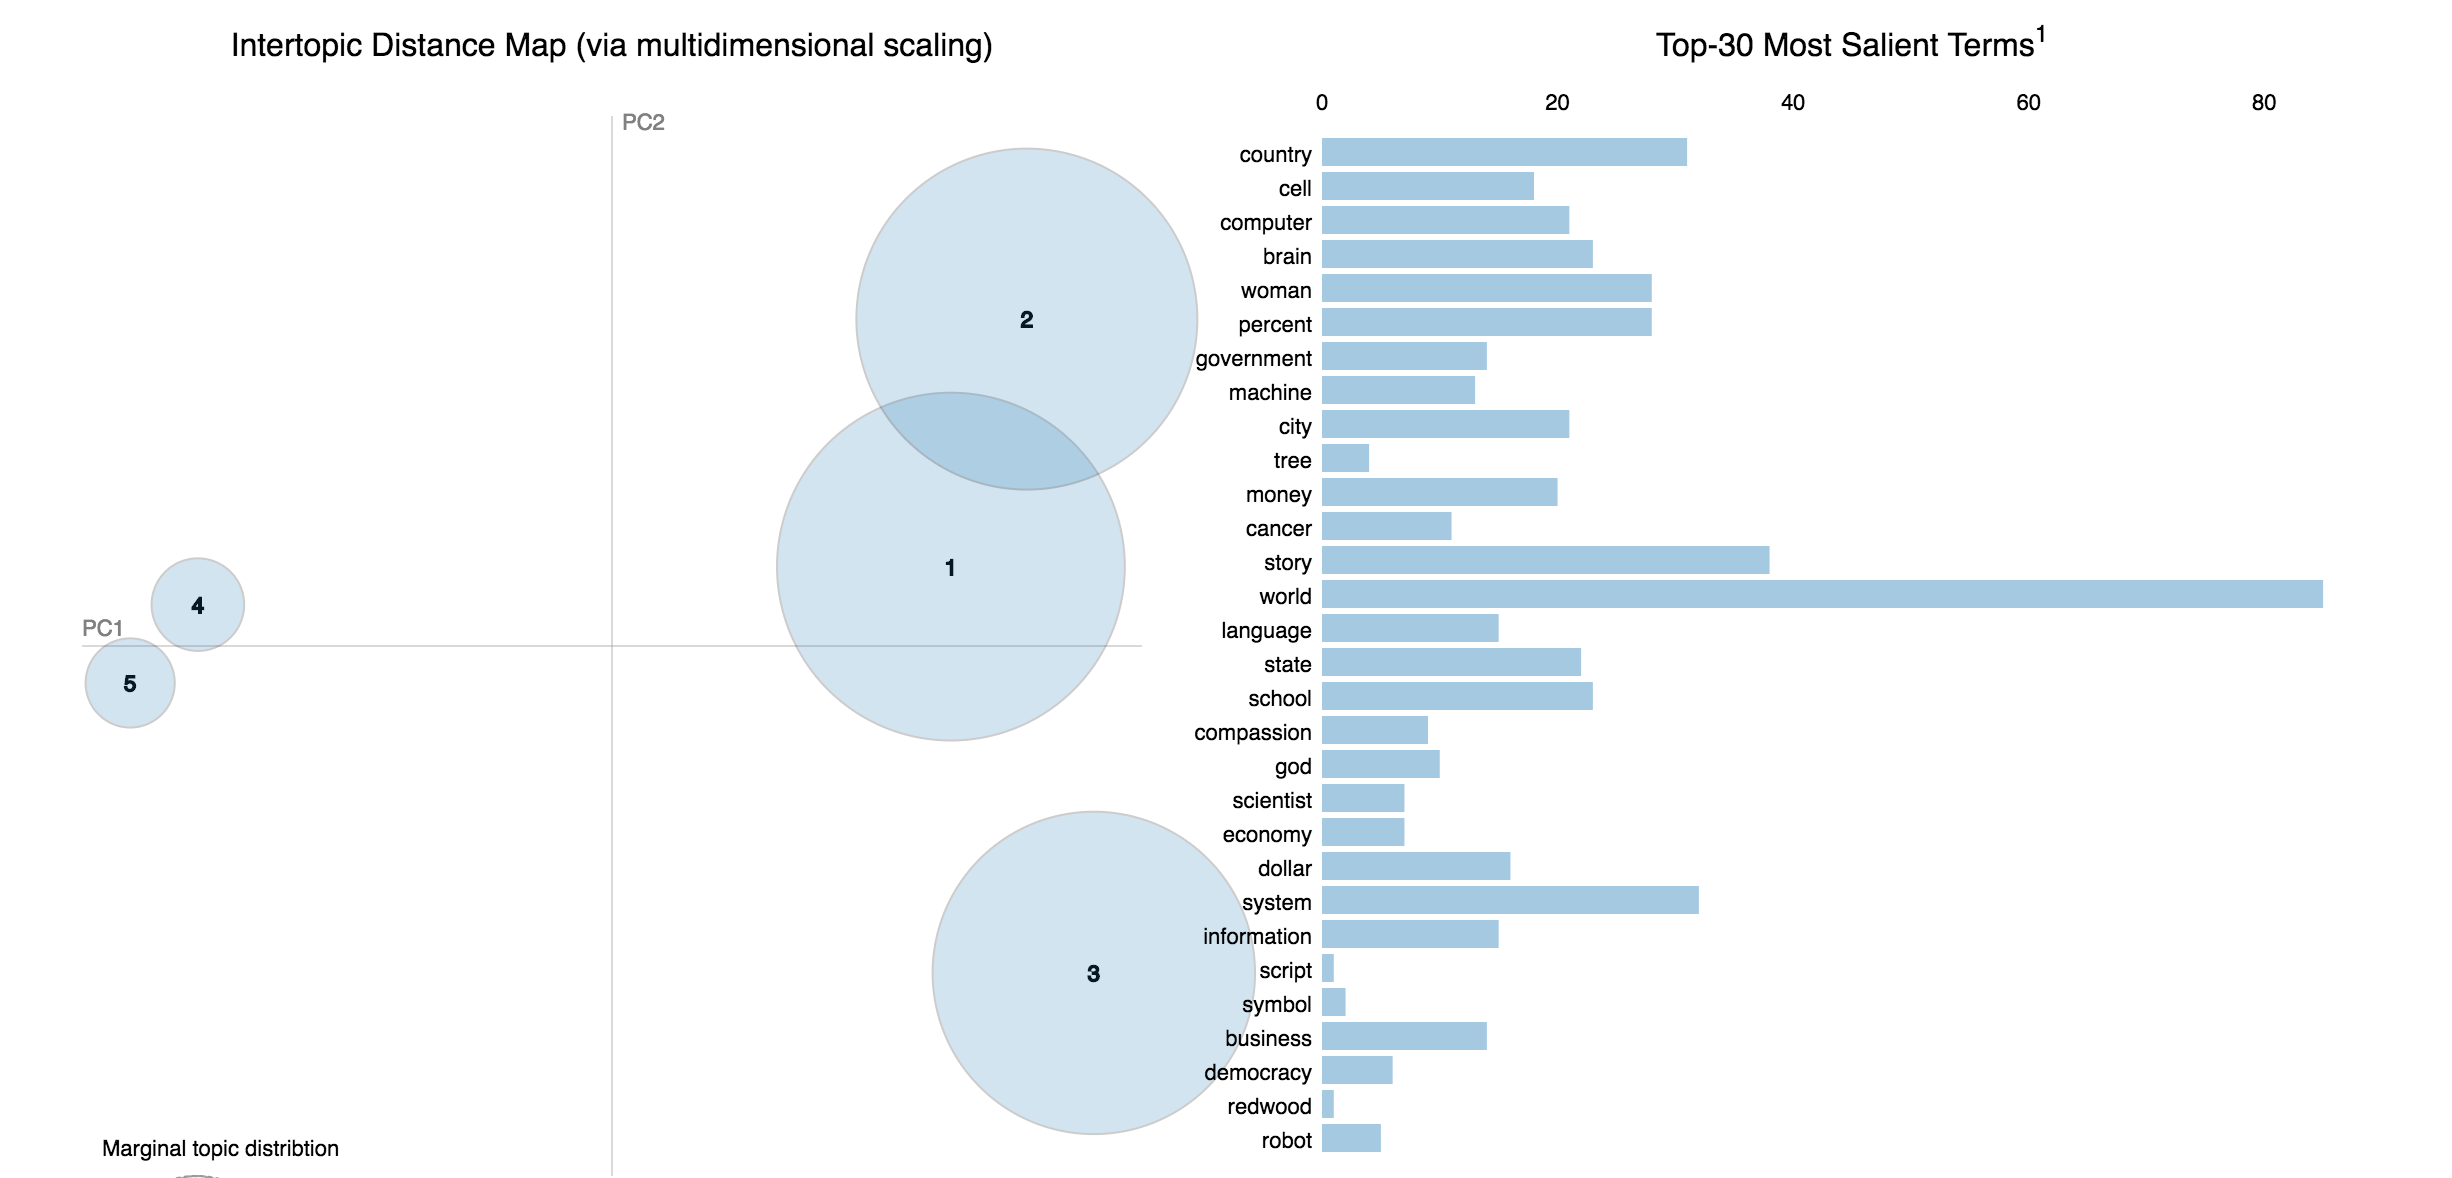

In [42]:
from IPython.display import Image
Image(filename, width=1000)

In [44]:
pyLDAvis.sklearn.prepare(lda,vectorized_tfidf,tfidf_model)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      70.534581        1       1 -0.140213 -0.071370
3      22.724597        1       2 -0.123164  0.076985
4       2.293140        1       3  0.085046 -0.000607
0       2.259868        1       4  0.093368 -0.005723
1       2.187814        1       5  0.084964  0.000715, topic_info=      Category       Freq            Term      Total  loglift  logprob
term                                                                  
1168   Default  29.000000           brain  29.000000  30.0000  30.0000
11375  Default  32.000000           woman  32.000000  29.0000  29.0000
9864   Default  38.000000           story  38.000000  28.0000  28.0000
3944   Default   4.000000          finger   4.000000  27.0000  27.0000
1425   Default  13.000000          cancer  13.000000  26.0000  26.0000
1582   Default  20.000000            cell  20.000000  25.0000  25.0000
2078   Default  10.000000      compassion  10.000000  24.0000  24.0000
6253   Default  21.000000             man  21.000000  23.0000  23.0000
4384   Default  11.000000             god  11.000000  22.0000  22.0000
1074   Default  18.000000            body  18.000000  21.0000  21.0000
5992   Default  64.000000            life  64.000000  20.0000  20.0000
2500   Default   4.000000          crisis   4.000000  19.0000  19.0000
4744   Default  11.000000           heart  11.000000  18.0000  18.0000
5095   Default  15.000000           image  15.000000  17.0000  17.0000
3751   Default  15.000000             eye  15.000000  16.0000  16.0000
3038   Default  12.000000         disease  12.000000  15.0000  15.0000
2917   Default   2.000000              dh   2.000000  14.0000  14.0000
6718   Default  16.000000          moment  16.000000  13.0000  13.0000
4610   Default  21.000000            hand  21.000000  12.0000  12.0000
3275   Default  10.000000            drug  10.000000  11.0000  11.0000
9298   Default   2.000000           shark   2.000000  10.0000  10.0000
6147   Default  12.000000            love  12.000000   9.0000   9.0000
6595   Default  13.000000            mind  13.000000   8.0000   8.0000
3763   Default  14.000000            face  14.000000   7.0000   7.0000
10780  Default   6.000000           trial   6.000000   6.0000   6.0000
6095   Default   1.000000            loan   1.000000   5.0000   5.0000
703    Default   3.000000            ball   3.000000   4.0000   4.0000
725    Default   4.000000            bank   4.000000   3.0000   3.0000
4042   Default  18.000000            food  18.000000   2.0000   2.0000
7577   Default  21.000000          person  21.000000   1.0000   1.0000
...        ...        ...             ...        ...      ...      ...
11394   Topic5   0.069547      wonderland   0.224923   2.6485  -7.8765
808     Topic5   0.040154         beanbag   0.133807   2.6186  -8.4258
935     Topic5   0.037745          beware   0.129074   2.5927  -8.4877
7206    Topic5   0.048897    osteoporosis   0.167575   2.5905  -8.2288
7000    Topic5   0.129339            node   0.451612   2.5719  -7.2561
2188    Topic5   0.096684  congratulation   0.449687   2.2852  -7.5471
703     Topic5   0.300873            ball   3.363675   1.4082  -6.4118
5560    Topic5   0.074900          jargon   0.355281   2.2655  -7.8024
4442    Topic5   0.143170            grab   1.448223   1.5082  -7.1545
6892    Topic5   0.077700       mythology   0.430755   2.1096  -7.7656
3667    Topic5   0.071503      excitement   0.374011   2.1677  -7.8488
8580    Topic5   0.094507          relief   0.740436   1.7637  -7.5698
1305    Topic5   0.103513          bullet   0.937586   1.6187  -7.4788
2172    Topic5   0.070346   configuration   0.396926   2.0919  -7.8651
4367    Topic5   0.050485          gloria   0.184796   2.5247  -8.1968
6718    Topic5   0.234136          moment  16.964314  -0.4607  -6.6626
8773    Topic5   0.105796         richard   2.009865   0.8780  -7.4570
2595    Topic5   0.085694    

## NMF - Topic Modeling using TFIDF 

In [45]:
#Build te NMF Model

nmf = NMF(init="nndsvd",
            n_components=5,
            max_iter=200)
nmf.fit(vectorized_tfidf)
topics_words = nmf.components_
words = tfidf_model.get_feature_names()

print("Topics in NMF model:")
tf_feature_names = tfidf_model.get_feature_names()
print_top_words(nmf, tf_feature_names)

Topics in NMF model:
Topic #0:
country|world|government|money|percent|state|dollar|business|school|democracy|health|economy|change|company|today|society|power|education|market|aid
Topic #1:
computer|music|machine|sort|technology|video|robot|design|project|information|car|phone|play|guy|language|image|world|space|person|sound
Topic #2:
woman|story|life|compassion|man|family|girl|child|mother|war|god|world|school|son|love|job|death|face|daughter|violence
Topic #3:
brain|cell|cancer|drug|disease|patient|body|trial|health|blood|tumor|gene|heart|neuron|treatment|stem|study|dna|doctor|culture
Topic #4:
water|city|planet|earth|energy|life|space|food|sea|plant|world|climate|place|system|change|ice|river|air|percent|story


## Manual labelling of the topics

0 -->  global

1 -->  technology

2 -->  science

3 --> entertainment

4 ---> business


## Checking performance of Topic Modeling

In [46]:
v = nmf.transform(vectorized_tfidf)

Counter([np.argmax(i) for i in v])

Counter({0: 151, 1: 323, 2: 196, 3: 117, 4: 191})

In [47]:
highest_weighted_topics = [np.argmax(i) for i in v]

> We can see that the documents are almost equally distributed over all the categories, which is how our initial data was divided into categories

### Manually labelling the topics 

In [48]:
p = []
for i in highest_weighted_topics:
    if i == 0:
        p.append("t") # global issues
    if i ==1:
        p.append("b") # tech
    if i ==2:
        p.append("s") # business
    if i ==3:
        p.append("g") # science
    if i ==4:
        p.append("e") # entertainment


# Very important ***  

# Make sure you label the topics manually every time you re-run NMF.  

# NMF assigns random numbers to the topics that it prints. So read the words , label the topics using the previous cell. That is ->   p....    and then check for accuracy

## I'm checking  for accuracy after doing the labeling 

In [49]:
print("accuracy of my topic modeling : ",np.round(accuracy_score(labels,p)*100),"%")

accuracy of my topic modeling :  9.0 %


## I'm getting an accuracy of 44% which is better than most of the classifiers that I tried on the tfidf matrix.


## Visualizing the NMF model: There is a clear seperation between the topics, and they all make perfect sense when we examine the words in each topic.

In [50]:
NMF_filename = 'https://github.com/ShaoniWang/NLP-with-Python/raw/master/images/NMF_clusters.png'

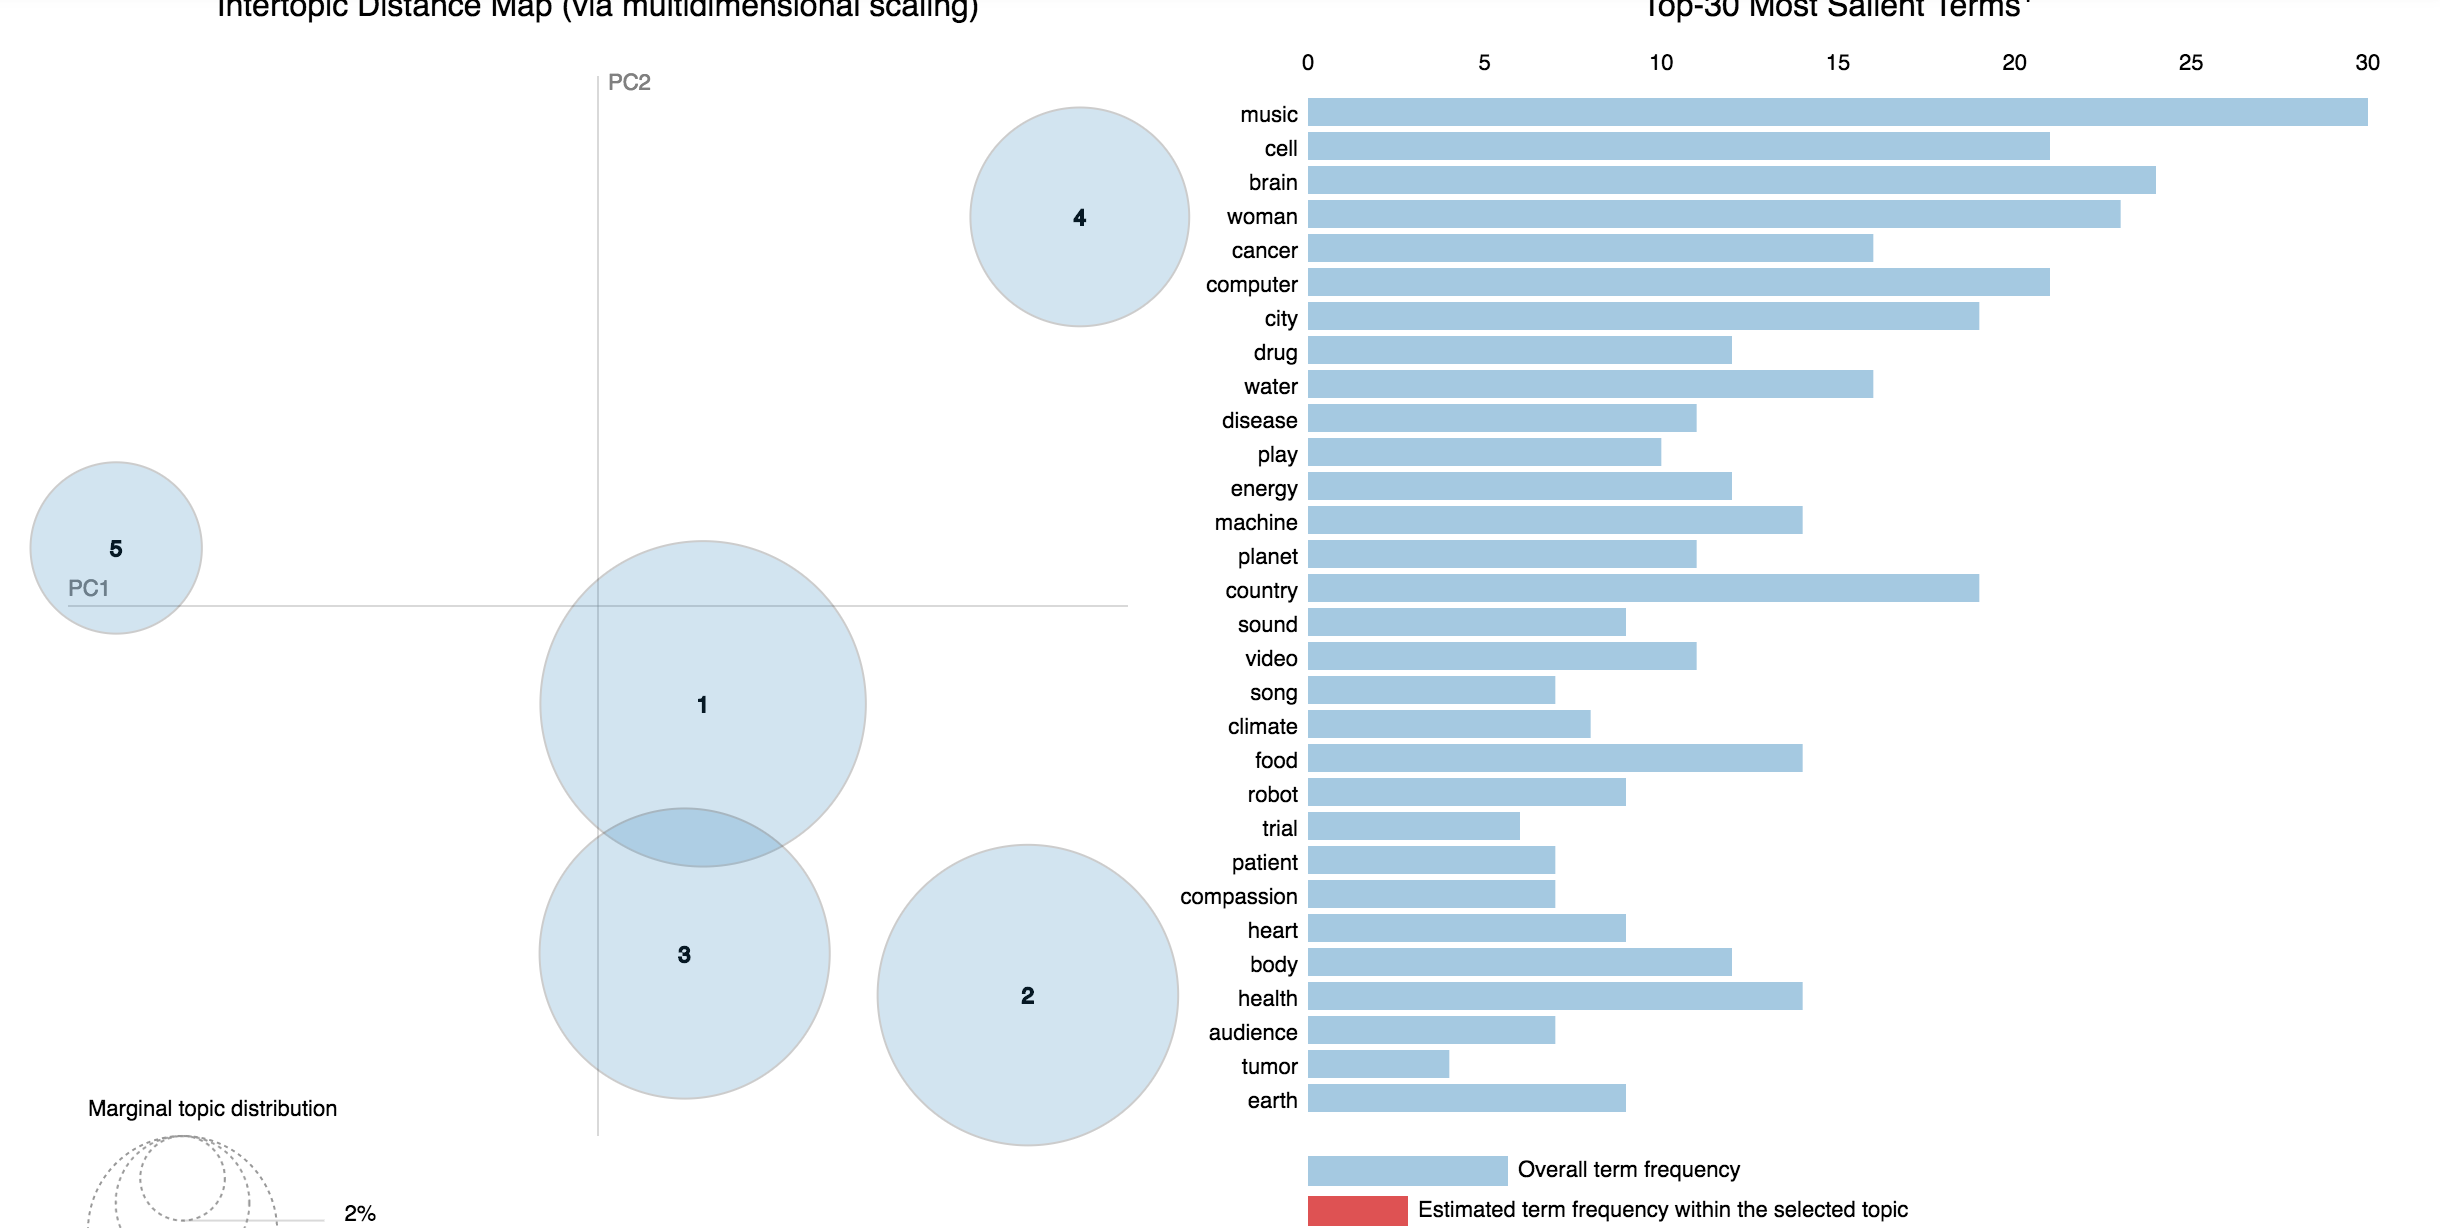

In [52]:
from IPython.display import Image
Image(NMF_filename, width=1000)

In [53]:
pyLDAvis.sklearn.prepare(nmf,vectorized_tfidf,tfidf_model)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      28.172592        1       1  0.011574 -0.008292
2      20.608824        1       2  0.164778  0.067385
4      19.680451        1       3 -0.107181 -0.199769
0      19.676011        1       4  0.129557 -0.013594
3      11.862122        1       5 -0.198728  0.154269, topic_info=      Category       Freq        Term      Total  loglift  logprob
term                                                              
11375  Default  30.000000       woman  30.000000  30.0000  30.0000
1168   Default  23.000000       brain  23.000000  29.0000  29.0000
1582   Default  19.000000        cell  19.000000  28.0000  28.0000
1425   Default  15.000000      cancer  15.000000  27.0000  27.0000
11201  Default  17.000000       water  17.000000  26.0000  26.0000
2124   Default  20.000000    computer  20.000000  25.0000  25.0000
2412   Default  19.000000     country  19.000000  24.0000  24.0000
7732   Default  12.000000      planet  12.000000  23.0000  23.0000
3275   Default  12.000000        drug  12.000000  22.0000  22.0000
4434   Default  12.000000  government  12.000000  21.0000  21.0000
1833   Default  17.000000        city  17.000000  20.0000  20.0000
2078   Default  10.000000  compassion  10.000000  19.0000  19.0000
3038   Default  11.000000     disease  11.000000  18.0000  18.0000
6869   Default  13.000000       music  13.000000  17.0000  17.0000
6179   Default  13.000000     machine  13.000000  16.0000  16.0000
3323   Default  10.000000       earth  10.000000  15.0000  15.0000
3489   Default  12.000000      energy  12.000000  14.0000  14.0000
6733   Default  11.000000       money  11.000000  13.0000  13.0000
4337   Default   9.000000        girl   9.000000  12.0000  12.0000
9864   Default  20.000000       story  20.000000  11.0000  11.0000
4733   Default  13.000000      health  13.000000  10.0000  10.0000
9127   Default   7.000000         sea   7.000000   9.0000   9.0000
11045  Default   9.000000       video   9.000000   8.0000   8.0000
8833   Default   9.000000       robot   9.000000   7.0000   7.0000
2791   Default   6.000000   democracy   6.000000   6.0000   6.0000
7429   Default   7.000000     patient   7.000000   5.0000   5.0000
9644   Default  14.000000       space  14.000000   4.0000   4.0000
10780  Default   6.000000       trial   6.000000   3.0000   3.0000
6796   Default   9.000000      mother   9.000000   2.0000   2.0000
7745   Default   7.000000       plant   7.000000   1.0000   1.0000
...        ...        ...         ...        ...      ...      ...
1522    Topic5   0.818036   cartilage   0.863643   2.0776  -7.1020
3275    Topic5   9.568651        drug  12.568791   1.8591  -4.6427
1043    Topic5   4.888632       blood   6.075194   1.9145  -5.3143
6168    Topic5   1.920448        lung   2.241257   1.9773  -6.2486
2369    Topic5   1.914605      cortex   2.234823   1.9772  -6.2517
10415   Topic5   1.868593     therapy   2.186598   1.9747  -6.2760
4271    Topic5   4.389572        gene   5.894758   1.8370  -5.4220
7429    Topic5   5.482316     patient   7.669927   1.7960  -5.1997
10762   Topic5   4.018955   treatment   5.537620   1.8113  -5.5102
2562    Topic5   2.073207        cure   2.691692   1.8707  -6.1721
1200    Topic5   2.568190      breast   3.605648   1.7925  -5.9580
6428    Topic5   2.250756    medicine   3.069111   1.8217  -6.0899
11026   Topic5   1.444042      vessel   1.788427   1.9179  -6.5338
8193    Topic5   2.280621     protein   3.216586   1.7879  -6.0767
3112    Topic5   3.621855         dna   5.883016   1.6467  -5.6142
10056   Topic5   2.382883     surgery   3.535223   1.7374  -6.0329
1074    Topic5   5.468738        body  11.807559   1.3621  -5.2021
4744    Topic5   4.250201       heart   8.884418   1.3945  -5.4542
6714    Topic5   2.677835    molecule   4.543144   1.6032  -5.9162
4733    Topic5   5.049162      health  13.113452   1.1774  -5.2820
3123    Topic5   3.414935   

## Default LDA

In [54]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X_train, X_test, y_train, y_test = train_test_split(vectorized_tfidf, labels, test_size=.5,random_state=0)
lda_ =  LinearDiscriminantAnalysis()
lda_.fit(X_train.toarray(),y_train)
y_pred = lda_.predict(X_test)
accuracy_score(y_test,y_pred)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


0.47034764826175868

In [55]:
conf = pd.DataFrame(confusion_matrix(y_true=y_test,y_pred=y_pred))
conf.columns = ["business","entertain","global","science","tech"]
conf.index = ["business","entertain","global","science","tech"]
conf.columns.name = "True\Predicted"
conf

True\Predicted,business,entertain,global,science,tech
business,6,1,25,4,29
entertain,2,8,28,11,30
global,1,0,91,3,19
science,0,2,14,50,43
tech,2,2,26,17,75


## ROC :

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


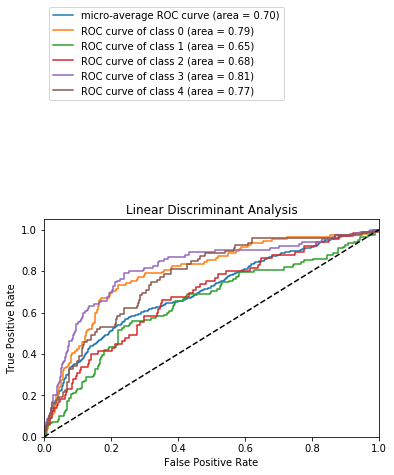

In [56]:
y = label_binarize(num_label, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]
X_train, X_test, y_train, y_test = train_test_split(df.speeches, y, test_size=.5,random_state=0)
cv = CountVectorizer()
cv.fit(X_train)
X_train,X_test = cv.transform(X_train),cv.transform(X_test)
classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
y_score = classifier.fit(X_train.toarray(), y_train).predict_proba(X_test)
#y_score[:,0]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:,i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Linear Discriminant Analysis")
plt.legend(bbox_to_anchor=(0, 2), loc='upper left', ncol=1)
plt.show()

## LSA

## I'll be printing the categories of the retreived documents  because its hard to judge the output using the title.

In [ ]:

v = []

query = "computer"

svd = TruncatedSVD(n_components=700)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(vectorized_tfidf)

X_dense = svd.inverse_transform(X)


query = "".join(char for char in query.lower() if char not in punctuation).split()

vocab = tfidf_model.get_feature_names()

query=np.array([1 if q in q else 0 for q in vocab])

if np.count_nonzero(query==1)==0:
    print("Keywords don't match with documents")
else:
    score = query.dot(X_dense.T)
    sort = sorted(zip(range(1,len(score)+1),score),key=lambda x:x[1],reverse=True)

    for i in range(len(sort[:10])):
        print((labels)[sort[i][0]])



Doc2Vec performs better than LSA. That's because the LSA model doesnt consider the best low-rank approximation of the oriiginal TFIDF matrix.

We can check how good the approximation is by computing Frobenius index. I did not have enough time to tune the LSA model. I was more focused on understanding Doc2Vec.

I had implemented LSA from scratch on the 20 news groups data, for which I computed the frobenius indx and tuned it. You can look at my other project repos on github to find it.

----------------------

# Just a fun thing  that I wanted to try

## Trying to predict number of views using number of pauses, laughters, applauses, sentiment :

In [283]:

X = df_eda[["pause","questions","laughter","applause","sentiment"]].values
y = np.array(df_eda.views)

model = sm.OLS(y.astype(int), X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     99.06
Date:                Fri, 16 Dec 2016   Prob (F-statistic):           1.83e-84
Time:                        14:48:35   Log-Likelihood:                -15744.
No. Observations:                 978   AIC:                         3.150e+04
Df Residuals:                     973   BIC:                         3.152e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -4426.8754   3089.948     -1.433      0.152   -1.05e+04    1636.854
x2          1.404e+04   6512.143      2.157      0.031    1264.182    2.68e+04
x3           3.27e+04   6511.696      5.021      0.000    1.99e+04    4.55e+04
x4          1.569e+05   1.77e+04      8.861      0.000    1.22e+05    1.92e+05
x5          3.308e+06   7.94e+05      4.165      0.000    1.75e+06    4.87e+06
==============================================================================
Omnibus:                     1277.403   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           291229.961
Skew:                           6.737   Prob(JB):                         0.00
Kurtosis:                      86.458   Cond. No.                         390.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Since we are able to explain only 34% of the variance. we cant use this to predict the views.

# Accuracy on TFIDF :

### SVM = 78%

### Random forest = 63%

### knn = 65%

### gradient boosting = 54%

### LDA =  49 %

# Accuracy on Doc2Vec document vectors :

### Random Forest = 57%

### Knn = 56.6%





# SVM Classifier gave me the best performance:


## parameters : [SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
## decision_function_shape=None, degree=3, gamma=1, kernel='sigmoid',
## max_iter=-1, probability=False, random_state=None, shrinking=True,
##  tol=0.001, verbose=False)]